# Uncapacitated Facility 

## Importing libraries

In [1]:
from docplex.mp.model import Model
import numpy as np
import math
import time
import heapq
import random
import matplotlib.pyplot as plt

## Functions for Lagrangian Relaxation

#### Calculating lower bound, X, Y and V value for Relaxed Constraint

In [2]:
def LRP(lda, num_facilities, J, I, d, h, f, alpha): 
    
    # Calculate V value 
    V = [0]*num_facilities
    for j in range(len(J)): 
        count = 0
        for i in range(len(I)): 
            count += min(0, alpha*h[i]*d[i][j] - lda[i])
        V[j] = count + f[j]
        
    # Calculate x
    x = [0]*num_facilities
    for i in range(len(V)): 
        if V[i] < 0: 
            x[i] = 1
        else: 
            x[i] = 0
            
    # Calculate y
    y = [[0] * num_facilities for i in range(num_facilities)]
    for i in range(len(I)): 
        for j in range(len(J)): 
            if x[j] == 1 and alpha*h[i]*d[i][j] - lda[i] < 0: 
                y[i][j] = 1
            else: 
                y[i][j] = 0
                
    # Calculate lower bound with relaxed constraint
    lb_ = sum(f[j]*x[j] for j in range(len(J))) + sum((alpha*h[i]*d[i][j] - lda[i])*y[i][j] for j in range(len(J)) for i in range(len(I))) + sum(lda[i] for i in range(len(I)))

    return lb_, x, y, V

#### Verify violations in the constraints 
- Add a facility when the relaxed solution does not include any one (The sum of x = 0)
- Assign a supplier to the facilities with no covered demand (The sum of Y_i = 0)
- Assign the closest supplier to the facility with more than one supplier (The sum of Y_i > 1)

In [3]:
def getViolatedConstraints(x_, y_, V_, num_facilities, I, d): 
    # Add a facility if no facilities where located using facility with the lowest V value 
    if sum(x_) <= 0: 
        x_[np.argmin(V_)] = 1
        
    # Index x with facilities 
    index = [i for i in range(len(x_)) if x_[i] == 1 ]

    # Store indexes for facilities with no demand satisfied and facilities with more than 2 suppliers
    violated_lambda_null = []
    violated_lambda_extra = []

    # Assign supplier to facilities with no demand covered to their neariest supplier or more than 2 suppliers 
    for i in range(len(I)): 
        
        # If no demand is satisfied, assign to nearest supplier
        if sum(y_[i]) <= 0: 
            minimum_index = None
            minimum_distance = 100000
            for j in index: 
                if  d[i][j] < minimum_distance: 
                    minimum_index = j
                    minimum_distance = d[i][j]
            violated_lambda_null.append(i)
        
            y_[i][minimum_index] = 1
        
        # If more than 2 suppliers, assign to nearest supplier
        if sum(y_[i]) >= 2:
            empty_list = [0] * num_facilities
            minimum_index = None
            minimum_distance = 100000
            for j in index: 
                if  d[i][j] < minimum_distance: 
                    minimum_index = j
                    minimum_distance = d[i][j]
                    
            violated_lambda_extra.append(i)
                    
            empty_list[minimum_index] = 1
            y_[i] = empty_list
            
    return violated_lambda_null, violated_lambda_extra, x_, y_, V_

#### Get upper bound with the original problem 

In [4]:
def solveFixed(x_, y_, f, d, I, J, alpha, h): 
    return sum(f[j]*x_[j] for j in range(len(J))) + alpha*sum(h[i]*d[i][j]*y_[i][j] for i in range(len(I)) for j in range(len(J)))

#### Update lambda for the facilities with the violated constraints

In [5]:
def update_lambda(violated_lambda_null, violated_lambda_extra, lr_alpha, ub, lb_, y, I, J, lda): 
    lda_ = lda
    
    # Calculate tn value 
    tn = lr_alpha*(ub-lb_)/sum(sum(y[i][j]-1 for i in range(len(I)))**2 for j in range(len(J)))
    
    # Substract from the lambda, the tn value to facilities with more than 2 suppliers
    if len(violated_lambda_extra) > 0:
        for i in violated_lambda_extra: 
            lda_[i] = lda_[i] - tn
        
    # Add from lambda, the tn value to facilities with no suppliers 
    if len(violated_lambda_null) > 0:
        for i in violated_lambda_null: 
            lda_[i] = lda_[i] + tn
            
    return lr_alpha, lda_

#### Lagrangian Implementation


In [6]:
def LRP_solver(J, I, d, h, f, alpha, lda, num_facilities, max_iter = 10000, max_nth = 8): 
    start_time = time.time()
    
    # Initializing variables 
    ub = float('inf') 
    lb = float('-inf')
    iter = 0
    lr_alpha = 2 # Alpha learning rate 
    lda_ = lda 

    nth_counter = 0 # Counter for lr_alpha update 

    # Historic upper and lower bound storage for plotting 
    list_ub = [] 
    list_lb = []

    while ub > lb: 
        
        # Get lower bound, x, y and V values using the relaxed constraint
        lb_, x, y, V = LRP(lda_, num_facilities, J, I, d, h, f, alpha)
        
        # Get violated constraints and update x and y values for the fixed problem implementation 
        violated_lambda_null, violated_lambda_extra, x, y, V = getViolatedConstraints(x, y, V, num_facilities, I, d)
        
        # Get upper bound for the fixed problem
        ub_ = solveFixed(x, y, f, d, I, J, alpha, h)
        
        # Update the nth_counter when the new lower bound is better than the current lower bound
        if lb_ > lb: 
            nth_counter = 0
        else:
            nth_counter += 1
            
        # Update lambda values
        if nth_counter < max_nth: 
            dummie, lda_ = update_lambda(violated_lambda_null, violated_lambda_extra, lr_alpha, ub_, lb_, y, I, J, lda_)
            
        # Update learning rate alpha if the lower bound has not improved in the nth iteration
        else: 
            lr_alpha = lr_alpha / 2
            dummie, lda_ = update_lambda(violated_lambda_null, violated_lambda_extra, lr_alpha, ub_, lb_, y, I, J, lda_)
            nth_counter = 0 

        # Update upper and lower bound values if they improve 
        if lb_ > lb: 
            lb = lb_
        
        if ub_ < ub: 
            ub = ub_
        
        # Store upper and lower bound values for plotting
        list_ub.append(ub)
        list_lb.append(lb)
        
        # Update iteration counter
        iter += 1
               
        # Stop code after reaching max_iterations  
        if iter >= max_iter: 
            break 
        
        # Stop code when the difference between the upper and lower bound is less than 0.0001
        if np.std([ub, lb]) < 0.0001: 
            break 
        
    # Print results 
    print('Time: ', time.time() - start_time)
    print('Objective Function: ', lb)
    print('Best Lower Bound: ', lb)
    print('Best Upper Bound: ', ub)
    print('Number of Iterations: ', iter)
    print('Facilities are located in: ', [J[i] for i in range(len(x)) if x[i] == 1 ])

    # Plot upper and lower bound values
    plt.plot(np.log(list_ub), label = 'Upper Bound')
    plt.plot(np.log(list_lb), label = 'Lower Bound')
    plt.show()

## Functions for large problem

#### Creation of random distance matrix 

In [7]:
# Create random distance matrix using Dikjstra algorithm
def get_dist_matrix(num_facilities_): 
    dist_matrix = np.zeros((num_facilities_, num_facilities_))
    for i in range(num_facilities_): 
        for j in range(num_facilities_): 
            if i == j: 
                dist_matrix[i][j] = 0
                break 
            else: 
                dist_matrix[i][j] = dist_matrix[j][i] = random.randint(1, 100)

    return dist_matrix.tolist()

#### Display of matrix 

In [8]:
def print_matrix(matrix): 
    for i in range(len(matrix)): 
        print('[', end = '')
        for j in range(len(matrix[0])): 
            print(matrix[i][j], end = ", ")       
        print('],', end='\n')    

## Solver using CPLEX

#### Definition of CPLEX solver

In [9]:
def solve_CPLEX(J, I, f, h, d, alpha):
    start_time = time.time()
    
    #Create an empty model
    mod=Model(name="LRP")
    
    #Decision Variables 
    
    # Open suppliers 
    x = {}
    for j in range(len(J)): 
        x[j] = mod.binary_var(name="x_"+str(j)) 
      
    # Demand assignment to suppliers 
    y = {}
    for j in range(len(J)): 
        for i in range(len(I)):
            y[i,j] = mod.continuous_var(name="y_"+str(i)+"_"+str(j),lb=0,ub=1)

    #Add constraints
    
    #Constraint to relax
    for i in range(len(I)):
        mod.add_constraint(sum(y[i,j] for j in range(len(J)))==1)
        
    #States that the demand at node i can not be asigned to a facility i forall I unless the facility j is open.
    for i in range(len(I)):
        for j in range(len(J)):
            mod.add_constraint(y[i,j] <= x[j])
            
    #Objective Function
    func_=mod.sum(f[j]*x[j] for j in range(len(J)))+(alpha*(mod.sum(h[i]*d[i][j]*y[i,j] for i in range(len(I)) for j in range(len(J)))))
    mod.minimize(func_)
    
    #Solve the model
    sol=mod.solve()
    
    #Print the solution
    print("Time: ", time.time() - start_time)
    print("Objective Function Value: ", sol.get_objective_value())
    print("Facilities are located in: ", [J[i] for i in range(len(J)) if x[i].solution_value == 1])

## Solution for book's problem

#### Definition of variables

In [10]:
num_facilities = 12

f= [100, 200, 130, 150, 225, 175, 190, 210, 165, 230, 125, 215] #fixed cost at node i
h= [15, 10, 12, 18, 5, 24, 11, 16, 13, 22, 19, 20] #demand at node i

# Distance matrix
d = [[0, 15, 37, 55, 24, 60, 18, 33, 48, 40, 58, 67],
 [15, 0, 22, 40, 38, 52, 33, 48, 42, 55, 61, 61],
 [37, 22, 0, 18, 16, 30, 41, 28, 20, 58, 39, 39],
 [55, 40, 18, 0, 34, 12, 59, 46, 24, 62, 43, 34],
 [24, 38, 16, 34, 0, 36, 25, 12, 24, 47, 37, 43],
 [60, 52, 30, 12, 36, 0, 57, 42, 12, 50, 31, 22],
 [18, 33, 41, 59, 25, 57, 0, 15, 45, 22, 40, 61],
 [33, 48, 28, 46, 12, 42, 15, 0, 30, 37, 25, 46],
 [48, 42, 20, 24, 24, 12, 45, 30, 0, 38, 19, 19],
 [40, 55, 58, 62, 47, 50, 22, 37, 38, 0, 19, 40],
 [58, 61, 39, 43, 37, 31, 40, 25, 19, 19, 0, 21],
 [67, 61, 39, 34, 43, 22, 61, 46, 19, 40, 21, 0]]

alpha = 0.35 #transportation cost per distance per unit

J = I = ['A','B','C','D','E','F','G','H','I','J','K','L'] #set of nodes

avg_demand = sum(h) / num_facilities
avg_fixed_cost = sum(f) / num_facilities

# Initialization of lambda 
lda_ = [10 * avg_demand + 10 * avg_fixed_cost] * num_facilities


#### Solution using CPLEX

In [11]:
solve_CPLEX(J, I, f, h, d, alpha)

Time:  0.0695180892944336
Objective Function Value:  1234.95
Facilities are located in:  ['A', 'D', 'K']


#### Solution using Lagrangian Approach

Time:  0.6351368427276611
Objective Function:  1234.9498000046997
Best Lower Bound:  1234.9498000046997
Best Upper Bound:  1234.9499999999998
Number of Iterations:  4034
Facilities are located in:  ['A', 'D', 'K']


C:\Users\cosme\AppData\Local\Temp\ipykernel_14432\2099868866.py:76: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(list_lb), label = 'Lower Bound')


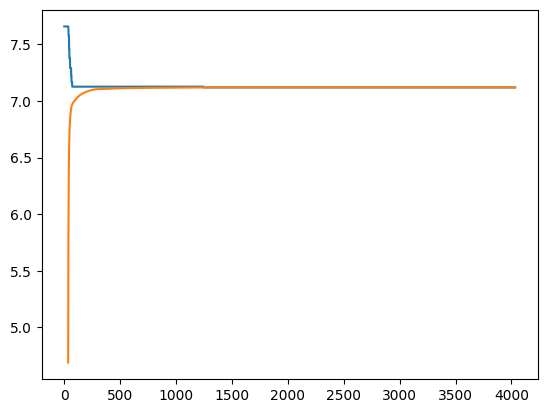

In [12]:
LRP_solver(J, I, d, h, f, alpha, lda_, num_facilities, max_iter = 10000, max_nth = 8)

## Solution for a large problem
We are limited to 30 nodes to use CPLEX solver due to quantity restrictions in the library for variables and constraints (up to 1000 each)

#### Creation of variables

In [13]:
num_facilities = int(input('Determine the number of facilities: ')) # Number of facilities

f = [np.random.randint(100, 250) for i in range(num_facilities)] # Fixed cost at node i
h = [np.random.randint(1, 50) for i in range(num_facilities)] # Demand at node i

alpha = float(input('Determine the value of alpha: ')) # Transportation cost per distance per unit

J = I = np.arange(num_facilities).tolist() # Set of nodes

# Definition of initial lambda 
avg_demand = sum(h) / num_facilities
avg_fixed_cost = sum(f) / num_facilities
lda = [10 * avg_demand + 10 * avg_fixed_cost] * num_facilities 

# Distance matrix creation 
d = get_dist_matrix(num_facilities)

#### CPLEX solution 

In [14]:
solve_CPLEX(J, I, f, h, d, alpha)

Time:  0.03202342987060547
Objective Function Value:  1598.4
Facilities are located in:  [0, 3, 4, 5, 8, 9, 12]


#### Lagrangian solution 

Time:  3.320309638977051
Objective Function:  1508.4951396386768
Best Lower Bound:  1508.4951396386768
Best Upper Bound:  1602.7
Number of Iterations:  10000
Facilities are located in:  [0, 3, 4, 5, 8, 9, 16]


C:\Users\cosme\AppData\Local\Temp\ipykernel_14432\2099868866.py:76: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(list_lb), label = 'Lower Bound')


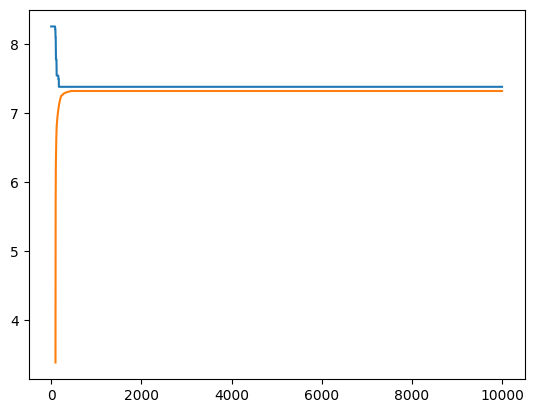

In [15]:
LRP_solver(J, I, d, h, f, alpha, lda, num_facilities, max_iter = 10000, max_nth = 8)